# 1 SETUP
***

In [1]:
# Notebook Config 
import sys
import os
proj_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(proj_root)


# Data Analysis
import pandas as pd
import numpy as np
import math

# Statistic
from scipy.stats import chi2_contingency

# DataViz 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from tqdm import tqdm 

# My Functions
from src.data_prep import DataPreparationPipeline
from src.utils import tab_freq

In [2]:
df_trans = pd.read_csv('../data/raw/train_transaction.csv')
df_id = pd.read_csv('../data/raw/train_identity.csv')

In [3]:
pipeline = DataPreparationPipeline(df_trans,df_id)
df_final = pipeline.feature_selection().df_merge()

# 2 DATA PREPARATION
***

## 2.1 EDA
***

Análise exploratória dos dados (EDA) para compreender a estrutura do conjunto, identificar inconsistências e definir os tratamentos adequados para cada variável.

In [4]:
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
TransactionID,590540.0,3.282270e+06,1.704744e+05,2987000.000,3134634.750,3282269.500,3429904.25,3.577539e+06
card1,590540.0,9.898735e+03,4.901170e+03,1000.000,6019.000,9678.000,14184.00,1.839600e+04
card2,581607.0,3.625555e+02,1.577932e+02,100.000,214.000,361.000,512.00,6.000000e+02
card3,588975.0,1.531949e+02,1.133644e+01,100.000,150.000,150.000,150.00,2.310000e+02
card5,586281.0,1.992789e+02,4.124445e+01,100.000,166.000,226.000,226.00,2.370000e+02
isFraud,590540.0,3.499001e-02,1.837546e-01,0.000,0.000,0.000,0.00,1.000000e+00
TransactionDT,590540.0,7.372311e+06,4.617224e+06,86400.000,3027057.750,7306527.500,11246620.00,1.581113e+07
TransactionAmt,590540.0,1.350272e+02,2.391625e+02,0.251,43.321,68.769,125.00,3.193739e+04


In [5]:

def df_info_completo(df):
    info_df = pd.DataFrame({
        "coluna": df.columns,
        "dtype": df.dtypes.values,
        "nulos": df.isnull().sum().values,
        "% nulos": (df.isnull().sum().values / len(df) * 100).round(2)
    })
    return info_df

info_df = df_info_completo(df_final)
display(info_df.head(50))
display(info_df.tail(27))

,coluna,dtype,nulos,% nulos
0,TransactionID,int64,0,0.00
1,card1,int64,0,0.00
2,card2,float64,8933,1.51
3,card3,float64,1565,0.27
4,card4,object,1577,0.27
5,card5,float64,4259,0.72
6,card6,object,1571,0.27
7,isFraud,int64,0,0.00
8,TransactionDT,int64,0,0.00
9,TransactionAmt,float64,0,0.00


,coluna,dtype,nulos,% nulos
0,TransactionID,int64,0,0.00
1,card1,int64,0,0.00
2,card2,float64,8933,1.51
3,card3,float64,1565,0.27
4,card4,object,1577,0.27
5,card5,float64,4259,0.72
6,card6,object,1571,0.27
7,isFraud,int64,0,0.00
8,TransactionDT,int64,0,0.00
9,TransactionAmt,float64,0,0.00


### 2.2.1 VARIÁVEIS DE CARTÃO
***
Nesta seção, será analisado as variáveis relacionadas aos cartões (card1 a card6) para entender padrões de consistência e ausência de informação.

* card1 será usada como identificação do cliente (granularidade do dataframe).

* card2–card6 serão avaliadas quanto à variabilidade entre transações do mesmo cartão e à ausência de informação, com o objetivo de criar features indicadoras de inconsistência ou falta de dados, que podem sinalizar risco de fraude.

In [6]:
df_card_analysis = df_final[['card1','card2','card3','card4','card5','card6','isFraud']]
df_card_analysis

# Calcular missing por card1 para cada card2–6
missing_dict = {}
for col in ['card2', 'card3', 'card4', 'card5', 'card6']:
    missing_dict[col] = df_card_analysis.groupby('card1')[col].apply(lambda x: x.isna().all())

missing_df = pd.DataFrame(missing_dict).reset_index()

print("Análise individual por variável de cartão:")
for col in ['card2', 'card3', 'card4', 'card5', 'card6']:
    tmp = (
        df_card_analysis.groupby('card1')[col]
        .agg(lambda x: x.nunique(dropna=True))
        .reset_index()
        .rename(columns={col: 'nunique'})
    )
    tmp['varia'] = tmp['nunique'] > 1
    tmp = tmp.merge(
        df_card_analysis[['card1', 'isFraud']].drop_duplicates('card1'),
        on='card1', how='left'
    )
    
    tmp['missing'] = missing_df.set_index('card1')[col].values

    taxa_varia = tmp.loc[tmp['varia'], 'isFraud'].mean()
    taxa_constante = tmp.loc[~tmp['varia'] & ~tmp['missing'], 'isFraud'].mean()
    taxa_missing = tmp.loc[tmp['missing'], 'isFraud'].mean()

    print(f"{col}:")
    print(f"   → Taxa se variou     = {taxa_varia:.3f}")
    print(f"   → Taxa se não variou = {taxa_constante:.3f}")
    print(f"   → Taxa sem informação = {taxa_missing:.3f}\n")

Análise individual por variável de cartão:
card2:
   → Taxa se variou     = 0.020
   → Taxa se não variou = 0.025
   → Taxa sem informação = 0.042

card3:
   → Taxa se variou     = 0.000
   → Taxa se não variou = 0.026
   → Taxa sem informação = 0.100

card4:
   → Taxa se variou     = nan
   → Taxa se não variou = 0.025
   → Taxa sem informação = 0.150

card5:
   → Taxa se variou     = 0.017
   → Taxa se não variou = 0.025
   → Taxa sem informação = 0.092

card6:
   → Taxa se variou     = 0.010
   → Taxa se não variou = 0.026
   → Taxa sem informação = 0.091



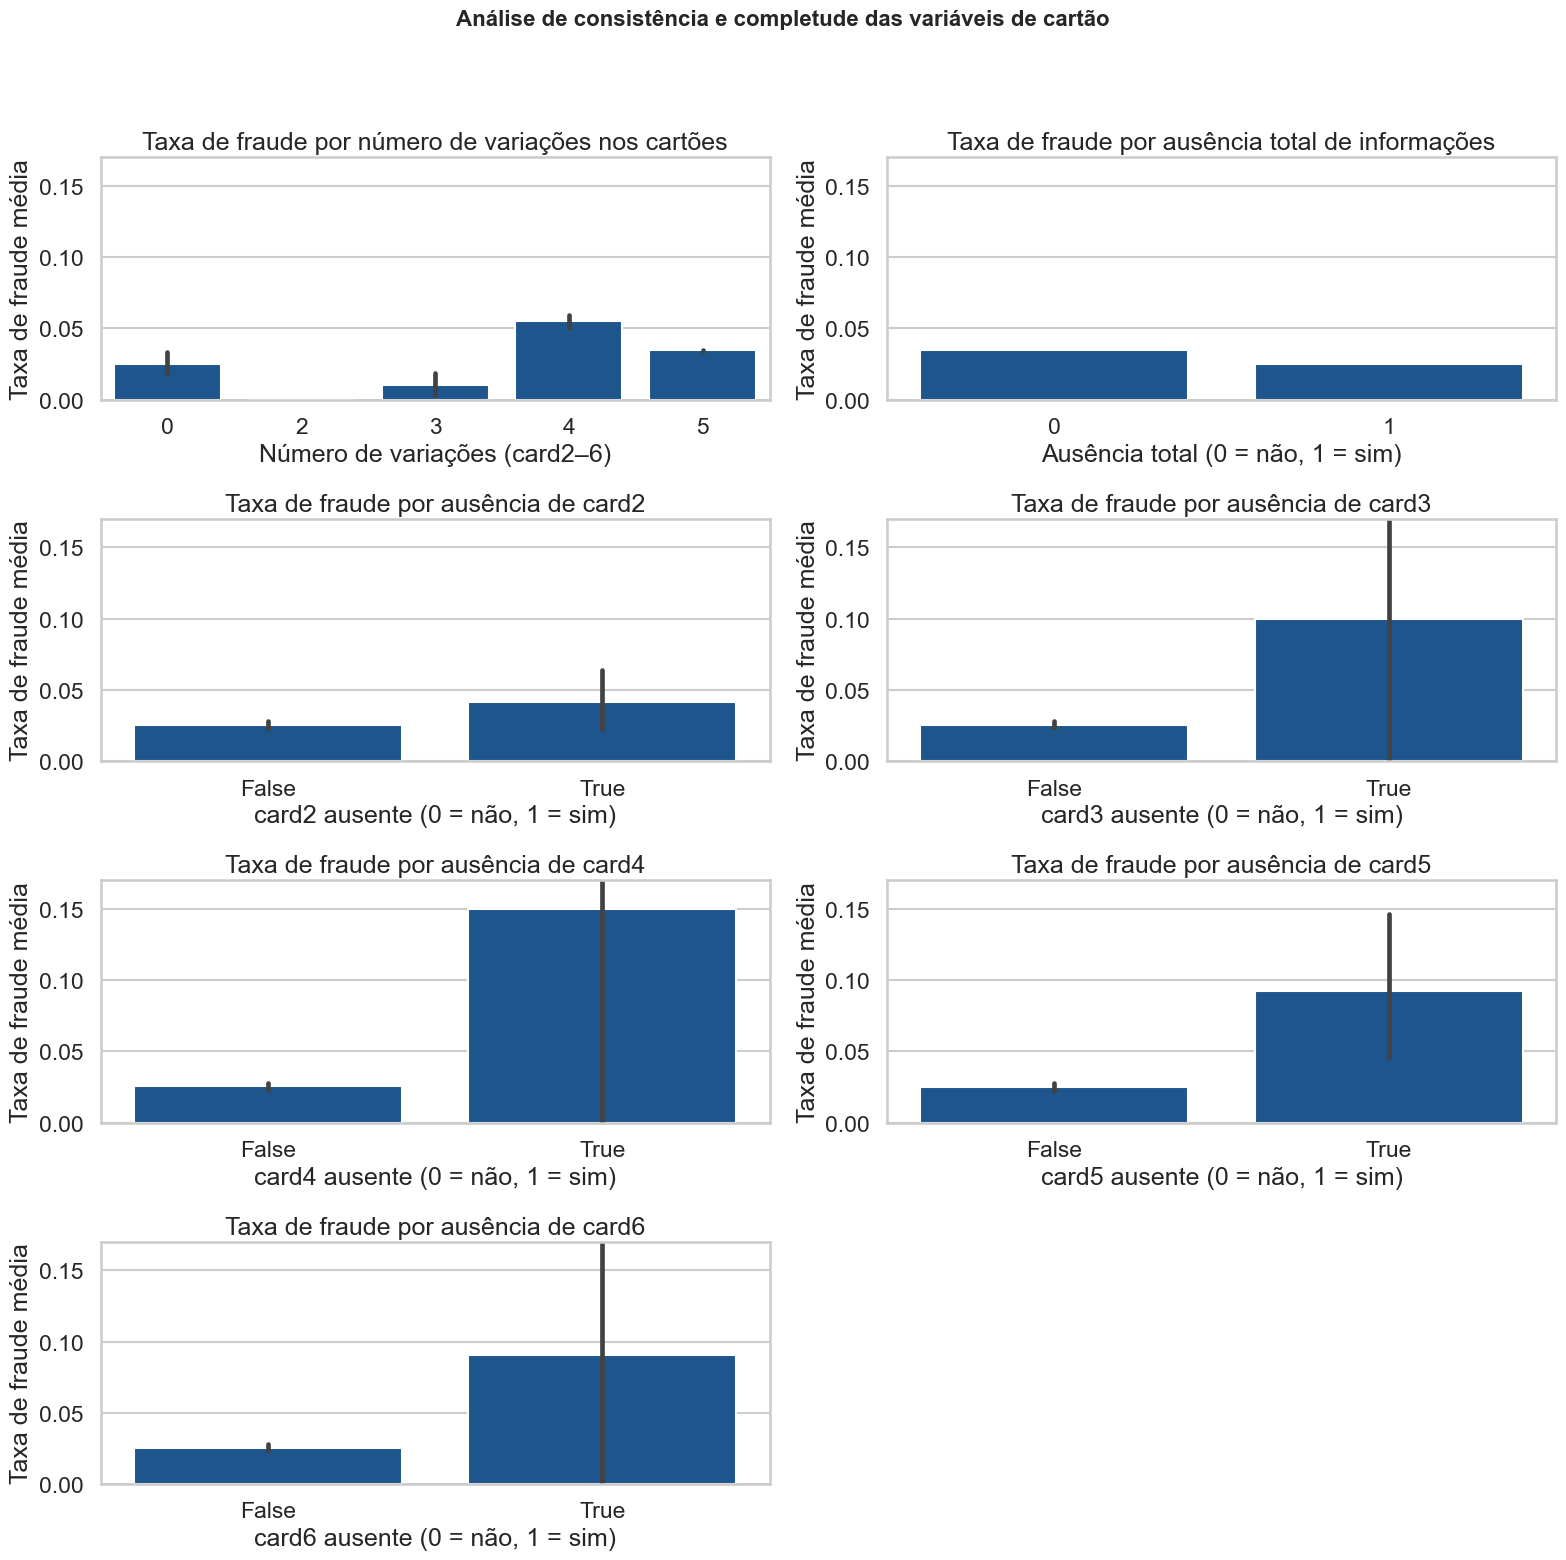

In [7]:

cards = ['card2', 'card3', 'card4', 'card5', 'card6']

df_card_info = df_final.copy()
df_card_info['num_card_diffs'] = df_card_info[cards].nunique(axis=1)
df_card_info['missing_card_info'] = df_card_info[cards].isna().all(axis=1).astype(int)

for col in cards:
    df_card_info[f'{col}_missing'] = df_card_info[col].isna().astype(int)
    
card_summary = {}
for col in cards:
    grouped = df_card_info.groupby(f'{col}_missing')['isFraud'].mean()
    card_summary[col] = {
        'taxa_presente': grouped.get(0, float('nan')),
        'taxa_ausente': grouped.get(1, float('nan'))
    }


sns.set(style="whitegrid", palette="Blues_r", context="talk")

cards = ['card2', 'card3', 'card4', 'card5', 'card6']

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(4, 2, figure=fig, height_ratios=[1, 1, 1, 1])
y_max = 0.17

ax0 = fig.add_subplot(gs[0, 0])
sns.barplot(
    x='num_card_diffs',
    y='isFraud',
    data=df_card_info,
    estimator='mean',
    ax=ax0
)
ax0.set_title('Taxa de fraude por número de variações nos cartões')
ax0.set_xlabel('Número de variações (card2–6)')
ax0.set_ylabel('Taxa de fraude média')
ax0.set_ylim(0, y_max)

ax1 = fig.add_subplot(gs[0, 1])
missing_rates = df_card_info.groupby('missing_card_info')['isFraud'].mean().reset_index()
sns.barplot(
    data=missing_rates,
    x='missing_card_info',
    y='isFraud',
    ax=ax1
)
ax1.set_title('Taxa de fraude por ausência total de informações')
ax1.set_xlabel('Ausência total (0 = não, 1 = sim)')
ax1.set_ylabel('Taxa de fraude média')
ax1.set_ylim(0, y_max)

for i, col in enumerate(cards):
    row = 1 + i // 2
    col_idx = i % 2
    if i == 4:  
        ax = fig.add_subplot(gs[3, 0])
    else:
        ax = fig.add_subplot(gs[row, col_idx])
    
    tmp = df_card_analysis.groupby('card1').agg(
        isFraud=('isFraud', 'first'),
        missing=(col, lambda x: x.isna().all())
    ).reset_index()
    
    sns.barplot(
        data=tmp,
        x='missing',
        y='isFraud',
        ax=ax
    )
    ax.set_title(f'Taxa de fraude por ausência de {col}')
    ax.set_xlabel(f'{col} ausente (0 = não, 1 = sim)')
    ax.set_ylabel('Taxa de fraude média')
    ax.set_ylim(0, y_max)

fig.add_subplot(gs[3, 1]).axis('off')

plt.suptitle('Análise de consistência e completude das variáveis de cartão', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

A taxa de fraude aumenta significativamente quando há ausência de informações (card2 a card6), indicando que campos faltantes podem ser um forte sinal de risco. A variabilidade das informações para o mesmo card1 tem efeito menor sobre a fraude, mudanças nos dados raramente sinalizam fraude por si só. Em análise individual: ausência de dados em card3, card4 e card6 apresenta maior taxa de fraude.

Próximo passo: criar features binárias indicando se cada variável de cartão está ausente ou não, para capturar o risco associado à falta de informação.

### 2.2.2 VARIÁVEIS CATEGORICAS
***
Exploração das variáveis categóricas.

In [8]:
cat_cols = [
    c for c in info_df.iloc[6:,:][info_df['dtype'] == 'object']['coluna'].to_list()
]

cat_cols = ['isFraud','card1','TransactionID'] + cat_cols
df_cat_analysis = df_final[cat_cols].copy()
df_cat_analysis = df_cat_analysis.fillna('missing')
df_cat_analysis

/var/folders/z7/yk0g4q2n7lvbcdw05xr3fljm0000gn/T/ipykernel_1087/2348349838.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c for c in info_df.iloc[6:,:][info_df['dtype'] == 'object']['coluna'].to_list()


,isFraud,card1,TransactionID,card6,ProductCD,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,DeviceType,DeviceInfo
0,0,13926,2987000,credit,W,missing,missing,T,T,T,M2,F,T,missing,missing,missing,missing,missing
1,0,2755,2987001,credit,W,gmail.com,missing,missing,missing,missing,M0,T,T,missing,missing,missing,missing,missing
2,0,4663,2987002,debit,W,outlook.com,missing,T,T,T,M0,F,F,F,F,F,missing,missing
3,0,18132,2987003,debit,W,yahoo.com,missing,missing,missing,missing,M0,T,F,missing,missing,missing,missing,missing
4,0,4497,2987004,credit,H,gmail.com,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0,6550,3577535,debit,W,missing,missing,T,T,T,M0,T,F,F,F,T,missing,missing
590536,0,10444,3577536,debit,W,gmail.com,missing,T,F,F,M0,F,T,F,F,F,missing,missing
590537,0,12037,3577537,debit,W,gmail.com,missing,T,F,F,missing,missing,T,missing,missing,missing,missing,missing
590538,0,7826,3577538,debit,W,aol.com,missing,T,T,T,M0,F,T,missing,missing,missing,missing,missing


#### PRODUCTCD
***
Categoria do produto/serviço adquirido.

In [9]:
tab_total_productcd = tab_freq(df_cat_analysis, 'ProductCD', 'isFraud')
tab_total_productcd

,ProductCD,pct_total,abs_total,pct_0,pct_1
0,C,11.602770,68519,88.312731,11.687269
1,H,5.592170,33024,95.233769,4.766231
2,R,6.383818,37699,96.217406,3.782594
3,S,1.969045,11628,94.100447,5.899553
4,W,74.452196,439670,97.960061,2.039939


A variável ProductCD apresenta diferenças claras na propensão à fraude. A categoria C apresenta a maior taxa de fraude (11,7%), enquanto W, responsável por mais de 70% das transações, apresenta apenas 2,1% de fraude. Isso indica que certas categorias carregam maior risco relativo, mesmo que sua frequência absoluta seja menor. Para análise e modelagem, a variável será transformada em uma feature contínua representando o risco de fraude associado a cada categoria.

#### P_EMAILDOMAIN & R_EMAILDOMAIN
***
Domínio do e-mail do pagador e recebedor.

##### P_EMAILDOMAIN

In [10]:
tab_total_P_emaildomain = tab_freq(df_cat_analysis, 'P_emaildomain', 'isFraud')
tab_total_P_emaildomain.sort_values(by=['pct_total','pct_1'], ascending=False)

,P_emaildomain,pct_total,abs_total,pct_0,pct_1
16,gmail.com,38.668845,228355,95.645815,4.354185
54,yahoo.com,17.091814,100934,97.724255,2.275745
31,missing,15.994852,94456,97.046244,2.953756
19,hotmail.com,7.662478,45250,94.704972,5.295028
1,anonymous.com,6.265113,36998,97.678253,2.321747
2,aol.com,4.790361,28289,97.818940,2.181060
9,comcast.net,1.335727,7888,96.881339,3.118661
23,icloud.com,1.061232,6267,96.856550,3.143450
36,outlook.com,0.862939,5096,90.541601,9.458399
32,msn.com,0.692925,4092,97.800587,2.199413


##### R_EMAILDOMAIN

In [11]:
tab_total_R_emaildomain = tab_freq(df_cat_analysis, 'R_emaildomain', 'isFraud')
tab_total_R_emaildomain.sort_values(by=['pct_total','pct_1'], ascending=False).head(60)

,R_emaildomain,pct_total,abs_total,pct_0,pct_1
31,missing,76.751617,453249,97.918142,2.081858
16,gmail.com,9.677075,57147,88.081614,11.918386
19,hotmail.com,4.658279,27509,92.220728,7.779272
1,anonymous.com,3.476310,20529,97.087048,2.912952
55,yahoo.com,2.005283,11842,94.848843,5.151157
2,aol.com,0.626715,3701,96.514456,3.485544
36,outlook.com,0.424527,2507,83.486239,16.513761
9,comcast.net,0.306838,1812,98.841060,1.158940
56,yahoo.com.mx,0.255360,1508,98.938992,1.061008
23,icloud.com,0.236732,1398,87.124464,12.875536


##### BIVARIATE ANALYSIS
***

Como existem muitos domínios, e o maior número de fraudes é sobre domínios raros, será realizado algumas análises olhando para o e-mail do pagador e recebedor ao mesmo tempo, para entender se existe algum sinal mais forte de anomalia. 

In [12]:
email_analysis = df_cat_analysis[['P_emaildomain','R_emaildomain','isFraud']].copy()

email_analysis['Same_Email'] = email_analysis['P_emaildomain'] == email_analysis['R_emaildomain']

popular_threshold = 0.01
popular_p = set(email_analysis["P_emaildomain"].value_counts(normalize=True)[lambda x: x >= popular_threshold].index)
popular_r = set(email_analysis["R_emaildomain"].value_counts(normalize=True)[lambda x: x >= popular_threshold].index)

email_analysis["P_email_popular"] = email_analysis["P_emaildomain"].isin(popular_p).astype(int)
email_analysis["R_email_popular"] = email_analysis["R_emaildomain"].isin(popular_r).astype(int)

def consistency_group(row):
    if row["P_email_popular"] and row["R_email_popular"]:
        return 3  # ambos populares
    elif row["P_email_popular"] and not row["R_email_popular"]:
        return 1  # pagador popular, recebedor raro
    elif not row["P_email_popular"] and row["R_email_popular"]:
        return 2  # pagador raro, recebedor popular
    else:
        return 0  # ambos raros
    

email_analysis["email_consistency_group"] = email_analysis.apply(consistency_group, axis=1)


In [13]:
tab_total_same_email= tab_freq(email_analysis, 'Same_Email', 'isFraud')
tab_total_same_email.sort_values(by=['pct_total'], ascending=False)

,Same_Email,pct_total,abs_total,pct_0,pct_1
0,False,68.521015,404644,97.866273,2.133727
1,True,31.478985,185896,93.529178,6.470822


In [14]:
tab_total_consistency_email = tab_freq(email_analysis, 'email_consistency_group', 'isFraud')
tab_total_consistency_email.sort_values(by=['pct_total'], ascending=False)

,email_consistency_group,pct_total,abs_total,pct_0,pct_1
3,3,91.217868,538678,96.485841,3.514159
2,2,5.350696,31598,97.895436,2.104564
0,0,1.778880,10505,93.783912,6.216088
1,1,1.652555,9759,95.747515,4.252485


Para capturar sinais de risco associados aos domínios de email envolvidos nas transações, serão criadas novas variáveis de feature engineering com base na consistência e histórico de fraude dos domínios:

1) email_consistency_group: variável categórica que indica a consistência entre os domínios do pagador e do recebedor. Grupos com combinações comuns e raras de domínios foram classificados de acordo com padrões observados nos dados. Essa variável permite identificar transações potencialmente anômalas quando os domínios não seguem os padrões típicos.

2) missing_p_domain e missing_r_domain: flags binárias indicando ausência de domínio para o pagador ou recebedor. A falta de informação pode ser indicativa de transações suspeitas, uma vez que domínios ausentes tendem a ter maior proporção de fraude.

3) high_risk_p_domain e high_risk_r_domain: flags binárias que sinalizam se o domínio do pagador ou recebedor possui historicamente uma alta taxa de fraude. Para definir “alto risco”, foram considerados domínios com proporção de fraude significativamente maior do que a média, independentemente da popularidade do domínio. Essa abordagem captura o fato de que mesmo domínios amplamente utilizados podem ser explorados por fraudadores, sendo relevante para a detecção de anomalias.

#### M1 - M9
***
Flags de comportamento associadas às transações. 

##### M1

In [15]:
tab_freq_m1 = tab_freq(df_cat_analysis, 'M1', 'isFraud')
tab_freq_m1

,M1,pct_total,abs_total,pct_0,pct_1
0,F,0.004233,25,100.000000,0.000000
1,T,54.088631,319415,98.014495,1.985505
2,missing,45.907136,271100,94.717447,5.282553


##### M2

In [16]:
tab_freq_m2 = tab_freq(df_cat_analysis, 'M2', 'isFraud')
tab_freq_m2

,M2,pct_total,abs_total,pct_0,pct_1
0,F,5.752701,33972,96.514777,3.485223
1,T,48.340163,285468,98.193142,1.806858
2,missing,45.907136,271100,94.717447,5.282553


##### M3

In [17]:
tab_freq_m3 = tab_freq(df_cat_analysis, 'M3', 'isFraud')
tab_freq_m3

,M3,pct_total,abs_total,pct_0,pct_1
0,F,11.465608,67709,96.973814,3.026186
1,T,42.627256,251731,98.294608,1.705392
2,missing,45.907136,271100,94.717447,5.282553


##### M4

In [18]:
tab_freq_m4 = tab_freq(df_cat_analysis, 'M4', 'isFraud')
tab_freq_m4

,M4,pct_total,abs_total,pct_0,pct_1
0,M0,33.258543,196405,96.335124,3.664876
1,M1,8.945372,52826,97.294893,2.705107
2,M2,10.137332,59865,88.626075,11.373925
3,missing,47.658753,281444,98.142792,1.857208


##### M5

In [19]:
tab_freq_m5 = tab_freq(df_cat_analysis, 'M5', 'isFraud')
tab_freq_m5

,M5,pct_total,abs_total,pct_0,pct_1
0,F,22.435567,132491,97.347744,2.652256
1,T,18.215024,107567,96.230256,3.769744
2,missing,59.349409,350482,96.264002,3.735998


##### M6

In [20]:
tab_freq_m6 = tab_freq(df_cat_analysis, 'M6', 'isFraud')
tab_freq_m6

,M6,pct_total,abs_total,pct_0,pct_1
0,F,38.584347,227856,97.631399,2.368601
1,T,32.736817,193324,98.295607,1.704393
2,missing,28.678836,169360,92.931625,7.068375


##### M7
***

In [21]:
tab_freq_m7 = tab_freq(df_cat_analysis, 'M7', 'isFraud')
tab_freq_m7

,M7,pct_total,abs_total,pct_0,pct_1
0,F,35.793342,211374,98.065514,1.934486
1,T,5.571341,32901,97.787301,2.212699
2,missing,58.635317,346265,95.423736,4.576264


##### M8
***

In [22]:
tab_freq_m8 = tab_freq(df_cat_analysis, 'M8', 'isFraud')
tab_freq_m8

,M8,pct_total,abs_total,pct_0,pct_1
0,F,26.289667,155251,97.827389,2.172611
1,T,15.077217,89037,98.378202,1.621798
2,missing,58.633115,346252,95.423564,4.576436


##### M9
***

In [23]:
tab_freq_m9 = tab_freq(df_cat_analysis, 'M9', 'isFraud')
tab_freq_m9

,M9,pct_total,abs_total,pct_0,pct_1
0,F,6.541809,38632,96.999896,3.000104
1,T,34.825075,205656,98.221302,1.778698
2,missing,58.633115,346252,95.423564,4.576436


Com exceção da variável M5, cujas categorias não apresentaram diferenças significativas na proporção de fraudes, as demais variáveis categóricas serão substituidas cada categoria pela sua taxa de ocorrência de fraude no conjunto de dados. Essa abordagem visa representar o risco histórico associado a cada categoria.

#### DeviceType e DeviceInfo
***
Nesta etapa, será exploradas variáveis relacionadas ao tipo e identificação do dispositivo utilizado nas transações, com o objetivo de capturar indícios de fraude associados a mudanças de comportamento tecnológico e ao perfil de uso dos clientes.

##### DeviceType
***

In [24]:
tab_freq_dt = tab_freq(df_cat_analysis, 'DeviceType', 'isFraud')
tab_freq_dt

,DeviceType,pct_total,abs_total,pct_0,pct_1
0,desktop,14.421546,85165,93.478542,6.521458
1,missing,76.155722,449730,97.898295,2.101705
2,mobile,9.422732,55645,89.833768,10.166232


##### DeviceInfo
***

In [25]:
tab_freq_di = tab_freq(df_cat_analysis, 'DeviceInfo', 'isFraud')
tab_freq_di.sort_values(by='pct_total', ascending=False).head(50)

,DeviceInfo,pct_total,abs_total,pct_0,pct_1
1735,missing,79.905510,471874,97.445081,2.554919
1598,Windows,8.081078,47722,93.460039,6.539961
1727,iOS Device,3.349815,19782,93.731675,6.268325
723,MacOS,2.129068,12573,97.788913,2.211087
1552,Trident/7.0,1.259864,7440,98.709677,1.290323
1744,rv:11.0,0.321909,1901,96.002104,3.997896
1770,rv:57.0,0.162902,962,89.293139,10.706861
1360,SM-J700M Build/MMB29K,0.092966,549,89.071038,10.928962
1199,SM-G610M Build/MMB29K,0.078064,461,91.973970,8.026030
1189,SM-G531H Build/LMY48B,0.069428,410,91.951220,8.048780


A variável `DeviceInfo` possui alta cardinalidade, resultante da grande diversidade de dispositivos e variações de nomenclatura (por exemplo, “Windows 10”, “Windows_10”, “Win10”). Essa característica inviabiliza a interpretação direta e dificulta a identificação de padrões agregados. Com o objetivo de permitir uma análise mais consistente, será realizada tratamento para fins exploratórios. As categorias serão padronizadas por meio de normalização textual (letras minúsculas e remoção de sufixos de versão) e posteriormente agrupadas em classes representativas (windows, ios, android, mac, linux, samsung, huawei e other).

In [26]:
df_cat_analysis['DeviceInfo'] = df_cat_analysis['DeviceInfo'].str.lower()

df_cat_analysis['DeviceInfo_clean'] = df_cat_analysis['DeviceInfo'].str.extract(
    r'(windows|ios|mac|android|samsung|huawei|linux)', expand=False
).fillna('other')

In [27]:
device_info_stats = (
    df_cat_analysis.groupby('DeviceInfo_clean')['isFraud']
      .agg(['count', 'mean'])
      .rename(columns={'count': 'n_trans', 'mean': 'fraud_rate'})
      .sort_values('fraud_rate', ascending=False)
)

device_info_stats

,n_trans,fraud_rate
DeviceInfo_clean,,
huawei,2415,0.135818
samsung,2692,0.081724
windows,47775,0.065536
ios,19782,0.062683
android,82,0.036585
other,505100,0.030614
mac,12573,0.022111
linux,121,0.000000


In [28]:
df_cat_analysis['changed_device'] = (
    df_cat_analysis
    .sort_values(['card1', 'TransactionID'])
    .groupby('card1')['DeviceInfo_clean']
    .apply(lambda x: (x != x.shift()).fillna(False).astype(int))
    .reset_index(level=0, drop=True)
)

df_cat_analysis.loc[
    df_cat_analysis.groupby('card1').head(1).index, 
    'changed_device'
] = 0

In [29]:
changed_device_stats = (
    df_cat_analysis.groupby('changed_device')['isFraud']
      .agg(['count', 'mean'])
      .rename(columns={'count': 'n_trans', 'mean': 'fraud_rate'})
      .sort_values('fraud_rate', ascending=False)
)

contingency = pd.crosstab(df_cat_analysis['changed_device'], df_cat_analysis['isFraud'])
chi2, p, dof, expected = chi2_contingency(contingency)

display(changed_device_stats)

if p < 0.05:
    print("p-valor < 0.05 → Rejeitamos H0: existe associação estatística entre mudança de dispositivo e fraude.")
else:
    print("p-valor ≥ 0.05 → Não rejeitamos H0: não há evidência de associação estatística entre mudança de dispositivo e fraude.")
display(contingency)

,n_trans,fraud_rate
changed_device,,
1,98703,0.051245
0,491837,0.031728


p-valor < 0.05 → Rejeitamos H0: existe associação estatística entre mudança de dispositivo e fraude.


isFraud,0,1
changed_device,,
0,476232,15605
1,93645,5058


##### 1) DeviceType

A análise inicial mostrou diferenças relevantes de taxa de fraude entre os tipos de dispositivos:

| Dispositivo | Taxa de Fraude |
|---|---|
| Mobile | 10,17% |
| Desktop | 6,52% |
| Missing (sem identificação) | 2,10% |

Esses resultados indicam que transações realizadas por dispositivos móveis apresentam risco mais elevado, com base será criada a variável binária:

is_mobile → 1 quando o dispositivo é móvel, 0 caso contrário.

##### 2️) Marca ou sistema do dispositivo (DeviceInfo)

Em seguida, foi analisada a taxa de fraude por marca/sistema, com os seguintes resultados:

DeviceInfo	Taxa de fraude
huawei	13,58%
samsung	8,17%
windows	6,55%
ios	6,27%
android	3,66%
other	3,06%
mac	2,21%
linux	0,00%

| Marca | Taxa de Fraude |
|---|---|
| Huawei | 13,58% |
| Samsung | 8,17% |
| Windows | 6,55% |
| IOS | 6,27% |
| Android | 3,66% |
| Other | 3,06% |
| MAC | 2,21% |
| Linux | 0,00% |

Com base nesses padrões, as marcas foram agrupadas conforme o risco histórico de fraude:

Alto risco: Huawei

Médio risco: Samsung, Windows, IOS

Baixo risco: Android, MAC, Linux, Other

Serão criadas duas variáveis derivadas:

device_risk_level → classifica o risco em baixo, médio ou alto

is_high_risk_device → 1 se o dispositivo pertence ao grupo de alto risco

##### 3) Mudança de dispositivo (DeviceInfo_clean)

Por fim, foi avaliado o impacto de mudanças de dispositivo ao longo do tempo. A taxa de fraude foi de 5,12% entre transações com mudança de dispositivo, contra 3,17% quando o dispositivo se manteve o mesmo. O teste qui-quadrado indicou associação estatisticamente significativa entre a variável e a ocorrência de fraude (p < 0,05), e será criada uma veriável binária de mudança de dispositivo:

changed_device → 1 quando o cliente realiza uma transação com dispositivo diferente do anterior, 0 caso contrário.

### 2.2.3 VARIÁVEIS NUMÉRICAS & DATA
***
Exploração das variáveis numéricas e de data.

In [30]:
num_cols = [
    c for c in info_df.iloc[6:,:][info_df['dtype'] != 'object']['coluna'].to_list()
]

#num_cols = ["isFraud"] + num_cols

df_num_analysis = df_final[num_cols].copy()
#df_num_analysis = df_num_analysis.fillna())
df_num_analysis

/var/folders/z7/yk0g4q2n7lvbcdw05xr3fljm0000gn/T/ipykernel_1087/1069256158.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c for c in info_df.iloc[6:,:][info_df['dtype'] != 'object']['coluna'].to_list()


,isFraud,TransactionDT,TransactionAmt
0,0,86400,68.50
1,0,86401,29.00
2,0,86469,59.00
3,0,86499,50.00
4,0,86506,50.00
...,...,...,...
590535,0,15811047,49.00
590536,0,15811049,39.50
590537,0,15811079,30.95
590538,0,15811088,117.00


#### DATA
***
Nesta seção, será explorado o comportamento temporal das transações, em especial:
- Padrões de ocorrência de fraudes por hora do dia;
- Identificação de horários atípicos;
- Transformações cíclicas para representação adequada do tempo.


In [31]:
df_final['TransactionDT2'] = pd.to_timedelta(df_final['TransactionDT'], unit='s')

date_components = df_final['TransactionDT2'].dt.components.iloc[:,:4]

date_components['hour_fractional'] = (
    date_components['hours'] +
    date_components['minutes'] / 60 +
    date_components['seconds'] / 3600
)

df_final = df_final.assign(day = date_components['days'],
                hour = date_components['hours'],
                minute = date_components['minutes'],
                second = date_components['seconds'],
                hour_fractional = date_components['hour_fractional']
                )



/var/folders/z7/yk0g4q2n7lvbcdw05xr3fljm0000gn/T/ipykernel_1087/2486769373.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


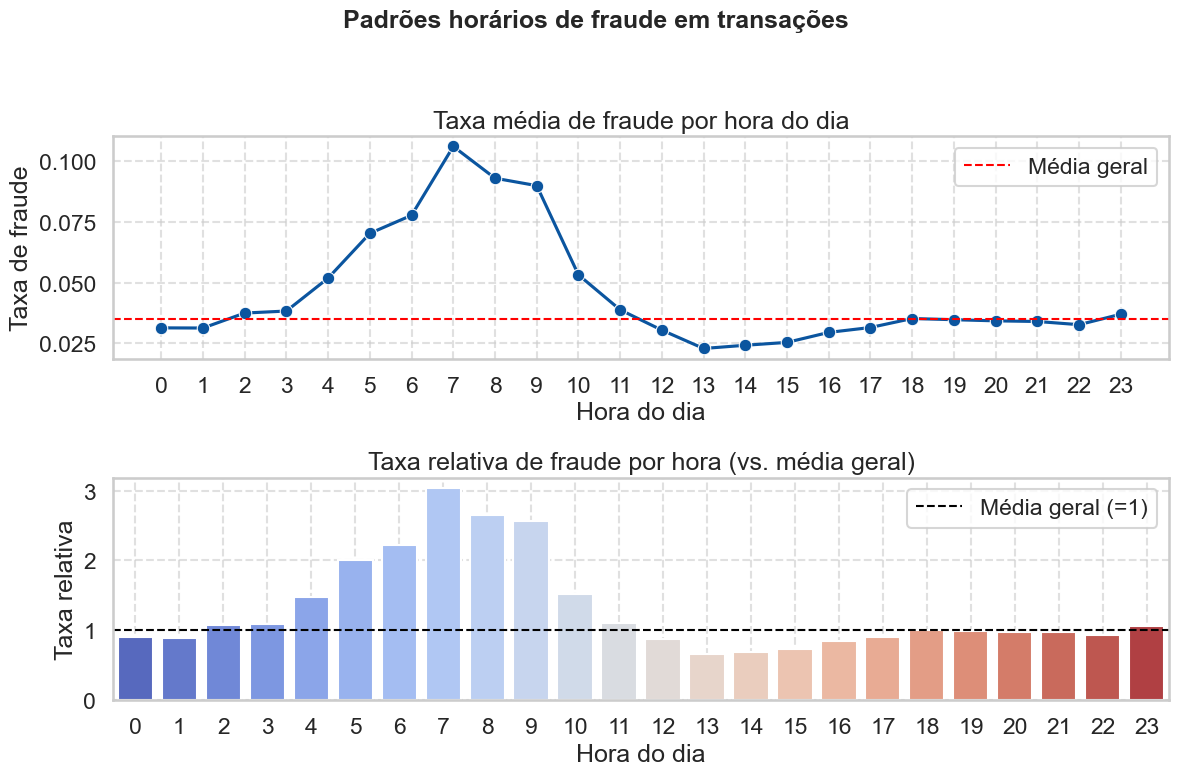

In [32]:
hourly_fraud = (
    df_final.groupby('hour')['isFraud']
    .agg(fraud_rate='mean', count='size')
    .reset_index()
)

overall_rate = df_final['isFraud'].mean()
hourly_fraud['relative_rate'] = hourly_fraud['fraud_rate'] / overall_rate


sns.set(style="whitegrid", palette="Blues_r", context="talk")

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

sns.lineplot(
    data=hourly_fraud,
    x='hour',
    y='fraud_rate',
    marker='o',
    ax=axes[0]
)
axes[0].axhline(overall_rate, color='red', linestyle='--', linewidth=1.5, label='Média geral')
axes[0].set_title('Taxa média de fraude por hora do dia')
axes[0].set_xlabel('Hora do dia')
axes[0].set_ylabel('Taxa de fraude')
axes[0].set_xticks(range(24))
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

sns.barplot(
    data=hourly_fraud,
    x='hour',
    y='relative_rate',
    ax=axes[1],
    palette="coolwarm"
)
axes[1].axhline(1, color='black', linestyle='--', linewidth=1.5, label='Média geral (=1)')
axes[1].set_title('Taxa relativa de fraude por hora (vs. média geral)')
axes[1].set_xlabel('Hora do dia')
axes[1].set_ylabel('Taxa relativa')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Padrões horários de fraude em transações', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

O gráfico por hora mostra que a taxa de fraude e fraude relativa à média geral (relative_rate) é mais alta em horários incomuns, especialmente entre 4h e 9h, indicando períodos potencialmente suspeitos para transações. Para o relative_rate valores acima de 1 indicam risco acima da média, enquanto valores abaixo de 1 indicam risco menor.

#### TRANSFORMACOES SENO E COSSENO

A transformação seno/cosseno permite representar variáveis cíclicas (hora, dia da semana) preservando a continuidade. Isso evita que o modelo interprete 23h e 0h como distantes, possibilitando detecção correta de padrões e anomalias ao longo do tempo.

#### TRANSACTIONAMT
***

Análise descritiva da variável `TransactionAmt`

count    590540.000000
mean        135.027176
std         239.162522
min           0.251000
1%            9.244000
5%           20.000000
25%          43.321000
50%          68.769000
75%         125.000000
95%         445.000000
99%        1104.000000
max       31937.391000
Name: TransactionAmt, dtype: float64


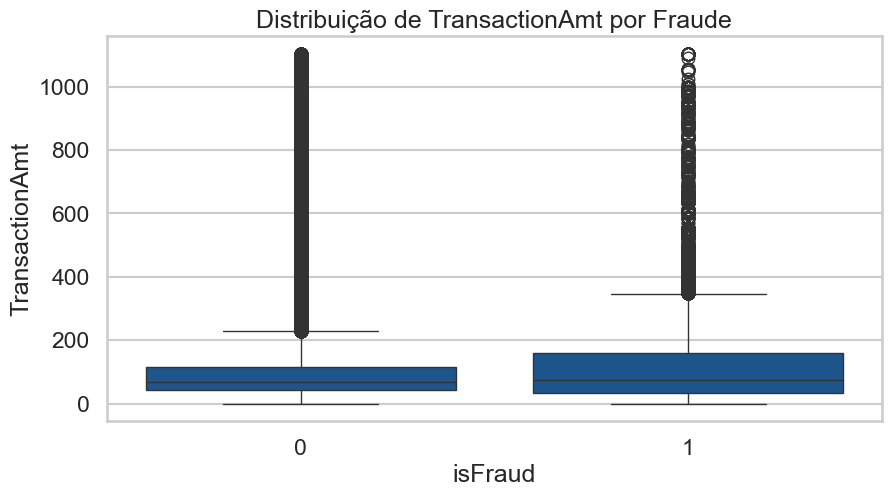

In [33]:
sns.set(style="whitegrid", context="talk", palette="Blues_r")

tx_stats = df_final['TransactionAmt'].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])
print(tx_stats)

# Boxplot
max_val = df_final['TransactionAmt'].quantile(0.99)
plt.figure(figsize=(10,5))
sns.boxplot(x='isFraud', y='TransactionAmt', data=df_final[df_final['TransactionAmt'] <= max_val])
plt.title('Distribuição de TransactionAmt por Fraude')
plt.show()

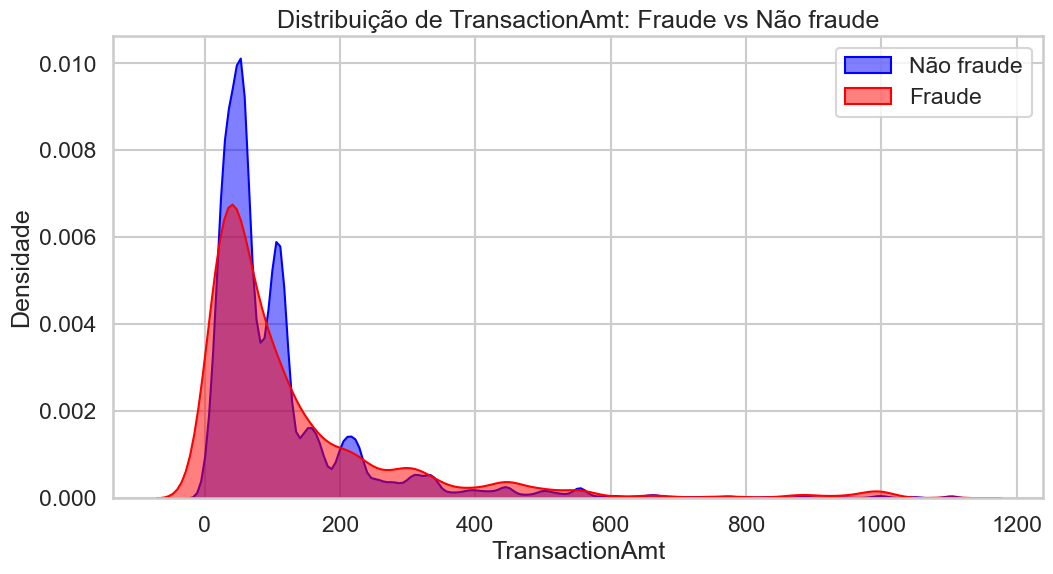

In [34]:
plt.figure(figsize=(12,6))

sns.kdeplot(
    df_final[df_final['TransactionAmt'] <= max_val].loc[df_final['isFraud']==0, 'TransactionAmt'], 
    fill=True, alpha=0.5, label='Não fraude', color='blue'
)
sns.kdeplot(
    df_final[df_final['TransactionAmt'] <= max_val].loc[df_final['isFraud']==1, 'TransactionAmt'], 
    fill=True, alpha=0.5, label='Fraude', color='red'
)

plt.xlabel('TransactionAmt')
plt.ylabel('Densidade')
plt.title('Distribuição de TransactionAmt: Fraude vs Não fraude')
plt.legend()
plt.show()

A análise da densidade das transações fraudulentas e legítimas mostra que ambas seguem distribuições muito semelhantes. Ou seja, não há uma faixa de valores claramente distinta que diferencie transações fraudulentas das não fraudulentas. Isso indica que o valor isolado da transação não é um forte discriminador de fraude, embora possa ser usado em combinação com outras variáveis ou em features derivadas (como agregações por períodos de tempo ou variações entre transações consecutivas).

#### DESLIZES TEMPORAIS
***

Análise descritiva da variável sobre deslizes temporais.

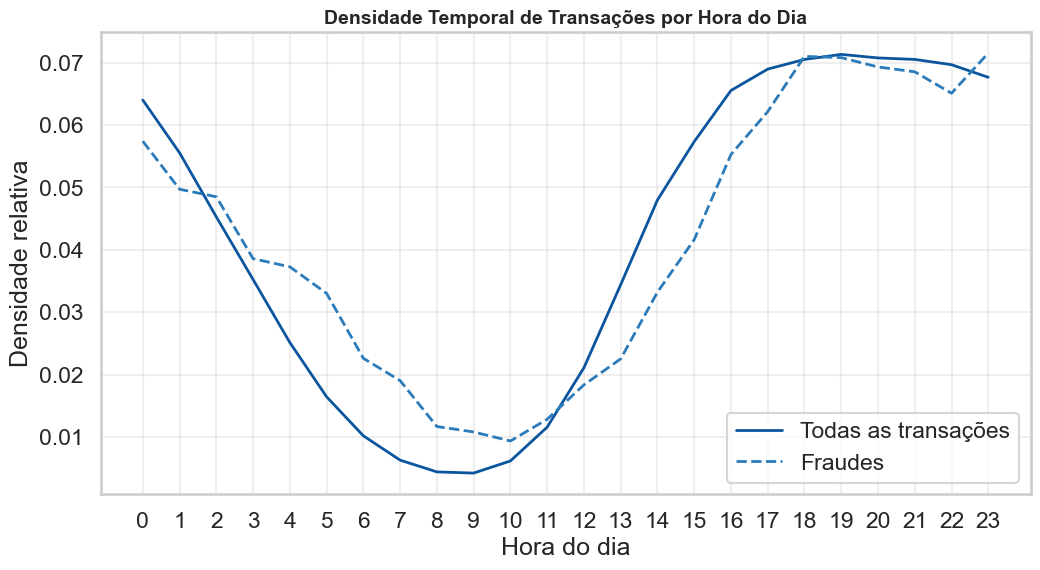

In [35]:
tx_density = (
    df_final.groupby('hour')
    .size()
    .reset_index(name='count_all')
)

fraud_density = (
    df_final[df_final['isFraud'] == 1]
    .groupby('hour')
    .size()
    .reset_index(name='count_fraud')
)

hour_density = pd.merge(tx_density, fraud_density, on='hour', how='left')
hour_density['count_fraud'] = hour_density['count_fraud'].fillna(0)

hour_density['density_all'] = hour_density['count_all'] / hour_density['count_all'].sum()
hour_density['density_fraud'] = hour_density['count_fraud'] / hour_density['count_fraud'].sum()

plt.figure(figsize=(12,6))
sns.lineplot(data=hour_density, x='hour', y='density_all', label='Todas as transações', linewidth=2)
sns.lineplot(data=hour_density, x='hour', y='density_fraud', label='Fraudes', linewidth=2, linestyle='--')
plt.title('Densidade Temporal de Transações por Hora do Dia', fontsize=14, fontweight='bold')
plt.xlabel('Hora do dia')
plt.ylabel('Densidade relativa')
plt.xticks(range(24))
plt.legend()
plt.grid(alpha=0.3)
plt.show()

A Figura acima apresenta a curva de densidade temporal das transações e das fraudes ao longo das 24 horas do dia.

Observa-se que:

* Entre 0h e 6h, há redução expressiva no volume total de transações, mas a densidade relativa de fraudes permanece elevada. Isso indica um período de alto risco relativo, possivelmente associado a atividades automatizadas ou horários de menor vigilância.

* Entre 6h e 14h, há aumento gradual no número de transações, enquanto a proporção de fraudes diminui, caracterizando um período de menor risco relativo.

* Entre 18h e 23h, o volume de transações atinge seu pico, e a densidade de fraudes cresce de forma proporcional, configurando um horário de risco absoluto elevado (maior número de fraudes em termos absolutos).

Esses resultados sugerem que o horário da transação é um preditor relevante do risco de fraude, motivando a criação de uma nova variável categórica (is_high_risk_hour) que considerará o risco temporal de "alto risco", segundo a exploração hoje estaria dividido em quatro níveis:

1) Alto risco: 0h–6h

2) Médio risco: 6h–12h

4) Baixo risco: 12h–18h

5) Médio/Alto risco: 18h–24h

Essa variável será incorporada ao conjunto de features do modelo de detecção de anomalias na próxima etapa.

Com base nessa análise, serão geradas features de deslize temporal (rolling windows) para capturar a dinâmica transacional dos clientes. O objetivo é medir, por exemplo, o número e o valor médio de transações realizadas nos últimos x minutos, horas ou dias, possibilitando a identificação de padrões anômalos de comportamento ao longo do tempo.

In [36]:

df = df_final.copy()  

df = df.sort_values(['card1', 'TransactionDT']).reset_index(drop=True)

windows = {
    '90d': 90 * 24 * 3600,
    '30d': 30 * 24 * 3600,
    '15d': 15 * 24 * 3600,
    '7d': 7 * 24 * 3600,
    '24h': 24 * 3600,
    '6h': 6 * 3600,
    '1h': 3600,
    '15m': 15 * 60,
    '5m': 5 * 60
}

def compute_windows_one_group(times, values, windows):
    """
    times: np.array (sorted) de tempos em segundos para 1 card1
    values: np.array de TransactionAmt (float) correspondente
    windows: dict label->seconds
    retorna: dict[label] -> dict com arrays 'count','mean','std' (mesmo comprimento de times)
    """
    n = len(times)
    out = {label: {'count': np.zeros(n, dtype=int),
                   'mean' : np.zeros(n, dtype=float),
                   'std'  : np.zeros(n, dtype=float)}
           for label in windows}
    if n == 0:
        return out

    psum = np.concatenate(([0.0], np.cumsum(values, dtype=float)))    # len n+1
    psum2 = np.concatenate(([0.0], np.cumsum(values * values, dtype=float)))

    idx = np.arange(n)

    for label, w in windows.items():
        left_idx = np.searchsorted(times, times - w, side='left')

        counts = idx - left_idx + 1  
        sums = psum[idx + 1] - psum[left_idx]
        sums2 = psum2[idx + 1] - psum2[left_idx]

        means = sums / counts
        vars_ = (sums2 / counts) - (means * means)
        vars_[vars_ < 0] = 0.0
        stds = np.sqrt(vars_)

        out[label]['count'] = counts
        out[label]['mean'] = means
        out[label]['std'] = stds

    return out

for label in windows:
    df[f'total_transaction_{label}'] = np.nan
    df[f'mean_transaction_value_{label}']  = np.nan
    df[f'std_transaction_value_{label}']   = np.nan

groups = df.groupby('card1', sort=False)
for card, g in tqdm(groups, total=df['card1'].nunique(), desc='Processing card1 groups'):
    idx = g.index.to_numpy()
    times = g['TransactionDT'].to_numpy()
    vals  = g['TransactionAmt'].to_numpy(dtype=float)

    order = np.argsort(times)
    times_o = times[order]
    vals_o  = vals[order]
    idx_o   = idx[order]
    res = compute_windows_one_group(times_o, vals_o, windows)
    
    for label in windows:
        df.loc[idx_o, f'total_transaction_{label}'] = res[label]['count']
        df.loc[idx_o, f'mean_transaction_value_{label}']  = res[label]['mean']
        df.loc[idx_o, f'std_transaction_value_{label}']   = res[label]['std']
        
df.head()


Processing card1 groups: 100%|██████████| 13553/13553 [00:36<00:00, 368.99it/s]


,TransactionID,card1,card2,card3,card4,card5,card6,isFraud,TransactionDT,TransactionAmt,...,std_transaction_value_6h,total_transaction_1h,mean_transaction_value_1h,std_transaction_value_1h,total_transaction_15m,mean_transaction_value_15m,std_transaction_value_15m,total_transaction_5m,mean_transaction_value_5m,std_transaction_value_5m
0,3230924,1000,555.0,185.0,mastercard,224.0,debit,0,5787419,23.443,...,0.0,1.0,23.443,0.0,1.0,23.443,0.0,1.0,23.443,0.0
1,3023634,1001,555.0,150.0,visa,226.0,debit,0,916268,183.000,...,0.0,1.0,183.000,0.0,1.0,183.000,0.0,1.0,183.000,0.0
2,3151336,1001,555.0,150.0,visa,226.0,debit,0,3504180,29.000,...,0.0,1.0,29.000,0.0,1.0,29.000,0.0,1.0,29.000,0.0
3,3210739,1001,555.0,150.0,visa,226.0,debit,0,5270458,27.000,...,0.0,1.0,27.000,0.0,1.0,27.000,0.0,1.0,27.000,0.0
4,3020767,1004,583.0,150.0,visa,226.0,credit,0,842821,150.000,...,0.0,1.0,150.000,0.0,1.0,150.000,0.0,1.0,150.000,0.0


Nesta etapa, foram criadas variáveis que resumem o comportamento transacional de cada cliente (card1) em diferentes janelas de tempo, com o objetivo de capturar padrões de frequência e valor que possam indicar anomalias.

As janelas temporais foram definidas de forma hierárquica e incremental, contemplando horizontes de curto, médio e longo prazo:

Curto prazo: 5 min, 15 min, 1h, 6h, 24h

Médio prazo: 7 dias, 15 dias, 30 dias

Longo prazo: 90 dias

Para cada janela, foram criadas as seguintes métricas:

total_transaction_X: número total de transações realizadas no período

mean_transaction_value_X: valor médio das transações

std_transaction_value_X: desvio padrão dos valores transacionais

A hipótese é que comportamentos de alta frequência e valores consistentes em janelas curtas podem estar associados a fraudes (por exemplo, múltiplas tentativas em poucos minutos), enquanto padrões estáveis e históricos longos indicam comportamento legítimo.

## 2.2 FEATURE ENGINEERING
***
Etapa dedicada à criação e transformação de variáveis com base nas análises realizadas na fase exploratória, visando aprimorar a capacidade explicativa do modelo.

In [37]:
df = df_final.copy()
cat_cols = [
    c for c in info_df.iloc[7:,:][info_df['dtype'] == 'object']['coluna'].to_list()
]
df.loc[:, cat_cols] = df.loc[:, cat_cols].fillna('missing')

/var/folders/z7/yk0g4q2n7lvbcdw05xr3fljm0000gn/T/ipykernel_1087/2891205065.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c for c in info_df.iloc[7:,:][info_df['dtype'] == 'object']['coluna'].to_list()


### 2.2.1 CARD FEATURES
***

Conforme explorado na etapa anterior, será criado uma função para detectar a ausencia de informações nas colunas complementares do cartão, o que aparenta carregar um sinal de fraude.

In [38]:
def card_features(df):
    CARD_COLUMNS = ['card2', 'card3', 'card4', 'card5', 'card6']
    for card_column in CARD_COLUMNS:
        df[f'{card_column}_missing'] = df[card_column].isna().astype(int)
        df.drop(columns = card_column, inplace=True)
    return df

### 2.2.2 CATEGORICAL FEATURES
***
Aplicação dos tratamentos definidos na etapa de exploração das variáveis.

#### 2.2.2.1 PROBABILIDADE CONDICIONAL 

In [39]:
def prob_cond_features(df):
    CATEGORICAL_COLUMNS = ['ProductCD','M1', 'M2', 'M3', 'M4','M6', 'M7', 'M8', 'M9']
    for cat_col in CATEGORICAL_COLUMNS: 
        fraud_rate = (pd.crosstab(df[cat_col], df['isFraud'], normalize='index')[1]).reset_index()
        fraud_rate.rename(columns={1:f'fraud_{cat_col}_rate'}, inplace=True)
        df = df.merge(fraud_rate, how='left', left_on=cat_col, right_on=cat_col)
        df.drop(columns=cat_col, inplace=True)
    return df

#### 2.2.2.2 EMAIL FEATURES 

In [40]:
def create_email_features(df,
                             p_col='P_emaildomain',
                             r_col='R_emaildomain',
                             fraud_col='isFraud',
                             popular_threshold=0.01,
                             high_risk_margin=0.02):
    """
    Cria as features de e-mail:
      - Same_Email
      - missing_p_domain, missing_r_domain
      - P_email_popular, R_email_popular (internas)
      - email_consistency_group (0..3 conforme sua lógica)
      - high_risk_p_domain, high_risk_r_domain (binárias)
      - device-friendly domain fraud rates (p_domain_fraud_rate, r_domain_fraud_rate)
    Parâmetros:
      df: DataFrame original (não modificado)
      p_col, r_col: nomes das colunas de domínio do pagador/recebedor
      fraud_col: nome da coluna target binária
      popular_threshold: frequência relativa mínima para considerar "popular" (ex: 0.01 = 1%)
      high_risk_margin: margem acima da taxa média global para marcar domínio como 'alto risco'
    Retorna:
      df_out: cópia de df com colunas adicionadas
    """
    df = df.copy()
    df[p_col] = df[p_col].astype(str).str.lower().str.strip().replace({'missing': np.nan})
    df[r_col] = df[r_col].astype(str).str.lower().str.strip().replace({'missing': np.nan})
    df['missing_p_domain'] = df[p_col].isna().astype(int)
    df['missing_r_domain'] = df[r_col].isna().astype(int)

    df['Same_Email'] = (df[p_col] == df[r_col]) & df[p_col].notna()

    p_counts = df[p_col].value_counts(normalize=True, dropna=True)
    r_counts = df[r_col].value_counts(normalize=True, dropna=True)

    popular_p = set(p_counts[p_counts >= popular_threshold].index)
    popular_r = set(r_counts[r_counts >= popular_threshold].index)

    df['P_email_popular'] = df[p_col].isin(popular_p).astype(int)
    df['R_email_popular'] = df[r_col].isin(popular_r).astype(int)

    def consistency_group_row(row):
        if row['P_email_popular'] and row['R_email_popular']:
            return 3
        elif row['P_email_popular'] and not row['R_email_popular']:
            return 1
        elif not row['P_email_popular'] and row['R_email_popular']:
            return 2
        else:
            return 0

    df['email_consistency_group'] = df.apply(consistency_group_row, axis=1)

    tmp = df.copy()
    tmp[p_col] = tmp[p_col].fillna('missing')
    tmp[r_col] = tmp[r_col].fillna('missing')
    p_domain_fraud = tmp.groupby(p_col)[fraud_col].mean().rename('p_domain_fraud_rate')
    r_domain_fraud = tmp.groupby(r_col)[fraud_col].mean().rename('r_domain_fraud_rate')
    global_rate = df[fraud_col].mean()
    p_high = p_domain_fraud[p_domain_fraud > (global_rate + high_risk_margin)].index
    r_high = r_domain_fraud[r_domain_fraud > (global_rate + high_risk_margin)].index

    df['high_risk_p_domain'] = df[p_col].isin(set(p_high)).astype(int)
    df['high_risk_r_domain'] = df[r_col].isin(set(r_high)).astype(int)
    
    df = df.drop(columns=['P_emaildomain','R_emaildomain','P_email_popular','R_email_popular'])

    return df

#### 2.2.2.2 DEVICE FEATURES 

In [41]:
def create_device_features(df):
    """
    Cria variáveis derivadas de DeviceType e DeviceInfo com base na análise exploratória.

    Features criadas:
    - is_mobile: 1 se o dispositivo é móvel, 0 caso contrário
    - device_risk_level: categórica (baixo, médio, alto)
    - is_high_risk_device: 1 se o dispositivo pertence ao grupo de alto risco
    - changed_device: 1 se houve mudança de dispositivo em relação à transação anterior do mesmo cliente
    - device_missing

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo colunas 'DeviceType', 'DeviceInfo_clean', 'card1' e 'TransactionDT' (ou outra temporal)
    """

    df = df.copy()
    # 1) is_mobile
    df["is_mobile"] = df["DeviceType"].str.lower().eq("mobile").astype(int)
    
    # 2) device_risk_level
    high_risk = ["huawei"]
    medium_risk = ["samsung", "windows", "ios"]
    low_risk = ["android", "mac", "linux", "other"]
    
    df['DeviceInfo'] = df['DeviceInfo'].str.lower()
    df['DeviceInfo_clean'] = df['DeviceInfo'].str.extract(
    r'(windows|ios|mac|android|samsung|huawei|linux)', expand=False
    ).fillna('other')

    def classify_risk(device):
        if pd.isna(device):
            return "missing"
        device = str(device).lower()
        if any(r in device for r in high_risk):
            return "alto"
        elif any(r in device for r in medium_risk):
            return "medio"
        elif any(r in device for r in low_risk):
            return "baixo"
        else:
            return "outro"

    df["device_risk_level"] = df["DeviceInfo_clean"].apply(classify_risk)
    df["is_high_risk_device"] = (df["device_risk_level"] == "alto").astype(int)
    
    # 3) changed_device
    df = df.sort_values(['card1', 'TransactionID'])

    df['changed_device'] = (
        df.groupby('card1')
        .apply(lambda g: (
            (g['DeviceInfo_clean'] != g['DeviceInfo_clean'].shift()) &
            g['DeviceInfo'].notna() & g['DeviceInfo'].shift().notna()
        ).astype(int))
        .reset_index(level=0, drop=True)
    )

    df.loc[
        df.groupby('card1').head(1).index, 
        'changed_device'
    ] = 0
    
    # 4) device_missing
    
    df['device_missing'] = df['DeviceInfo'].apply(lambda x: x == 'missing').astype(int)
    
    # 5) Drop Columns 
    
    df.drop(columns=['DeviceType','DeviceInfo','DeviceInfo_clean','device_risk_level'], inplace=True)


    return df

#### 2.2.2.2 FINAL TEST

In [42]:
teste_df = card_features(df)
teste_df = prob_cond_features(teste_df)
teste_df = create_email_features(teste_df)
teste_df = create_device_features(teste_df)
teste_df.head()

/var/folders/z7/yk0g4q2n7lvbcdw05xr3fljm0000gn/T/ipykernel_1087/2154698536.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (


,TransactionID,card1,isFraud,TransactionDT,TransactionAmt,M5,TransactionDT2,day,hour,minute,...,missing_p_domain,missing_r_domain,Same_Email,email_consistency_group,high_risk_p_domain,high_risk_r_domain,is_mobile,is_high_risk_device,changed_device,device_missing
243924,3230924,1000,0,5787419,23.443,missing,66 days 23:36:59,66,23,36,...,0,0,True,3,0,1,1,0,0,0
36634,3023634,1001,0,916268,183.000,T,10 days 14:31:08,10,14,31,...,0,1,False,1,0,0,0,0,0,1
164336,3151336,1001,0,3504180,29.000,T,40 days 13:23:00,40,13,23,...,0,1,False,1,0,0,0,0,0,1
223739,3210739,1001,0,5270458,27.000,T,61 days 00:00:58,61,0,0,...,0,1,False,1,0,0,0,0,0,1
33767,3020767,1004,0,842821,150.000,missing,9 days 18:07:01,9,18,7,...,0,0,False,3,0,0,0,0,0,0


### 2.2.3 DATE + TRANSACTION FEATURES
***
Aplicação dos tratamentos definidos na etapa de exploração das variáveis.

#### 2.2.3.1 DATE FEATURES

In [43]:
def date_features(df):
    
    # 1) Date Preparation
    
    df['TransactionDT2'] = pd.to_timedelta(df['TransactionDT2'], unit='s')
    date_components = df['TransactionDT2'].dt.components.iloc[:,:4]
    
    date_components['hour_fractional'] = (
    date_components['hours'] +
    date_components['minutes'] / 60 +
    date_components['seconds'] / 3600
    )
    
    df = df.assign(day = date_components['days'],
                hour = date_components['hours'],
                minute = date_components['minutes'],
                second = date_components['seconds'],
                hour_fractional = date_components['hour_fractional']
                )
    
    # 2) Transformation Seno & Cosseno
    
    df['hour_sin'] = np.sin(2 * np.pi * df['hour_fractional'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour_fractional'] / 24)
    
    # 3) is_high_risk_hour
    
    df['is_high_risk_hour'] = (
    ((df['hour'] > 0) & (df['hour'] < 6)) |
    ((df['hour'] > 18) & (df['hour'] < 24))
    ).astype(int)
    
    
    # 4) Drop Columns 
    
    df.drop(columns=['TransactionDT2','day','hour','minute','second','hour_fractional'],inplace=True)
    
    return df
    
    

#### 2.2.3.2 TRANSACTION FEATURES

In [44]:
def transaction_features(df):
    
    # 1) Create Transaction Features

    df = df.sort_values(['card1', 'TransactionDT']).reset_index(drop=True)

    windows = {
        '90d': 90 * 24 * 3600,
        '30d': 30 * 24 * 3600,
        '15d': 15 * 24 * 3600,
        '7d': 7 * 24 * 3600,
        '24h': 24 * 3600,
        '6h': 6 * 3600,
        '1h': 3600,
        '15m': 15 * 60,
        '5m': 5 * 60
    }

    def compute_windows_one_group(times, values, windows):
        """
        times: np.array (sorted) de tempos em segundos para 1 card1
        values: np.array de TransactionAmt (float) correspondente
        windows: dict label->seconds
        retorna: dict[label] -> dict com arrays 'count','mean','std' (mesmo comprimento de times)
        """
        n = len(times)
        out = {label: {'count': np.zeros(n, dtype=int),
                    'mean' : np.zeros(n, dtype=float),
                    'std'  : np.zeros(n, dtype=float)}
            for label in windows}
        if n == 0:
            return out

        psum = np.concatenate(([0.0], np.cumsum(values, dtype=float)))    # len n+1
        psum2 = np.concatenate(([0.0], np.cumsum(values * values, dtype=float)))

        idx = np.arange(n)

        for label, w in windows.items():
            left_idx = np.searchsorted(times, times - w, side='left')

            counts = idx - left_idx + 1  
            sums = psum[idx + 1] - psum[left_idx]
            sums2 = psum2[idx + 1] - psum2[left_idx]

            means = sums / counts
            vars_ = (sums2 / counts) - (means * means)
            vars_[vars_ < 0] = 0.0
            stds = np.sqrt(vars_)

            out[label]['count'] = counts
            out[label]['mean'] = means
            out[label]['std'] = stds

        return out

    for label in windows:
        df[f'total_transaction_{label}'] = np.nan
        df[f'mean_transaction_value_{label}']  = np.nan
        df[f'std_transaction_value_{label}']   = np.nan

    groups = df.groupby('card1', sort=False)
    for card, g in tqdm(groups, total=df['card1'].nunique(), desc='Processing card1 groups'):
        idx = g.index.to_numpy()
        times = g['TransactionDT'].to_numpy()
        vals  = g['TransactionAmt'].to_numpy(dtype=float)

        order = np.argsort(times)
        times_o = times[order]
        vals_o  = vals[order]
        idx_o   = idx[order]
        res = compute_windows_one_group(times_o, vals_o, windows)
        
        for label in windows:
            df.loc[idx_o, f'total_transaction_{label}'] = res[label]['count']
            df.loc[idx_o, f'mean_transaction_value_{label}']  = res[label]['mean']
            df.loc[idx_o, f'std_transaction_value_{label}']   = res[label]['std']
    
            
    # 2) Drop Columns 
    
    df.drop(columns=['TransactionAmt','TransactionDT'],inplace=True)
    
    return df 


In [45]:
teste_df = date_features(teste_df)
teste_df = transaction_features(teste_df)
teste_df.head()

Processing card1 groups: 100%|██████████| 13553/13553 [00:36<00:00, 371.82it/s]


,TransactionID,card1,isFraud,M5,card2_missing,card3_missing,card4_missing,card5_missing,card6_missing,fraud_ProductCD_rate,...,std_transaction_value_6h,total_transaction_1h,mean_transaction_value_1h,std_transaction_value_1h,total_transaction_15m,mean_transaction_value_15m,std_transaction_value_15m,total_transaction_5m,mean_transaction_value_5m,std_transaction_value_5m
0,3230924,1000,0,missing,0,0,0,0,0,0.116873,...,0.0,1.0,23.443,0.0,1.0,23.443,0.0,1.0,23.443,0.0
1,3023634,1001,0,T,0,0,0,0,0,0.020399,...,0.0,1.0,183.000,0.0,1.0,183.000,0.0,1.0,183.000,0.0
2,3151336,1001,0,T,0,0,0,0,0,0.020399,...,0.0,1.0,29.000,0.0,1.0,29.000,0.0,1.0,29.000,0.0
3,3210739,1001,0,T,0,0,0,0,0,0.020399,...,0.0,1.0,27.000,0.0,1.0,27.000,0.0,1.0,27.000,0.0
4,3020767,1004,0,missing,0,0,0,0,0,0.037826,...,0.0,1.0,150.000,0.0,1.0,150.000,0.0,1.0,150.000,0.0


### 2.2.4 FINAL CLASS
#### Implementação do Pipeline de Preparação de Dados com Prevenção de Data Leakage
***
Nesta etapa, foi desenvolvida uma classe unificada para o pipeline completo de preparação de dados, incorporando as lógicas previamente validadas. A principal inovação implementada refere-se ao tratamento de variáveis dependentes do target, onde foi aplicada uma estratégia de cálculo condicional baseada no modo de operação (treino/teste).

Para variáveis que requerem conhecimento do target - como taxas de fraude condicionais e encodings baseados em frequência - o pipeline foi estruturado em duas fases distintas:

Modo Treino: Calcula e armazena parâmetros estatísticos (fit)

Modo Inferência: Aplica parâmetros previamente aprendidos (transform)

Esta abordagem assegura que, em ambiente de produção, onde o target não está disponível, o modelo utilize valores consistentes com a distribuição observada durante o treinamento, eliminando completamente o data leakage e garantindo a robustez do sistema em operação real.


In [ ]:
class DataPreparationPipeline:
    """
    Pipeline completo para preparação de dados em detecção de fraude
    Complete data preparation pipeline for fraud detection
    """
    
    def __init__(self, df_transaction: pd.DataFrame, df_identity: pd.DataFrame, 
                 is_training: bool = True, fitted_params: dict = None):
        """
        Inicializa o pipeline com dados de transação e identidade
        Initializes pipeline with transaction and identity data
        
        Args:
            df_transaction: DataFrame com dados transacionais / Transaction data
            df_identity: DataFrame com dados de identidade / Identity data  
            is_training: Se é dados de treino / Whether it's training data
            fitted_params: Parâmetros aprendidos no treino / Parameters learned during training
        """
        # Variáveis base para processamento
        # Base variables for processing
        self.transaction_features = [
            'TransactionID', 'TransactionDT', 'TransactionAmt',
            'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
            'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6',
            'M7', 'M8', 'M9'
        ]

        # Inclui target apenas no treino
        # Include target only in training
        if is_training:
            self.transaction_features.append('isFraud')

        self.identity_features = ['TransactionID', 'DeviceType', 'DeviceInfo']

        # DataFrames de trabalho
        # Working DataFrames
        self.df_transaction = df_transaction
        self.df_identity = df_identity
        self.merged_df = pd.DataFrame()
        self.df_final = pd.DataFrame()
        
        # Configuração do modo
        # Mode configuration
        self.is_training = is_training
        self.fitted_params = fitted_params if fitted_params else {}
        
        # Parâmetros aprendidos durante treinamento
        # Parameters learned during training
        self.fraud_rates_dict_ = self.fitted_params.get('fraud_rates_dict', {})
        self.email_popular_domains_ = self.fitted_params.get('email_popular_domains', {'P': set(), 'R': set()})
        self.email_fraud_rates_ = self.fitted_params.get('email_fraud_rates', {'P_high_risk': set(), 'R_high_risk': set()})
        self.global_fraud_rate_ = self.fitted_params.get('global_fraud_rate', 0)

    def feature_selection(self):
        """
        Seleciona features relevantes baseado na lista definida
        Selects relevant features based on defined list
        """
        # Filtra colunas existentes nos dados
        # Filters existing columns in data
        tx_cols = [c for c in self.transaction_features if c in self.df_transaction.columns]
        id_cols = [c for c in self.identity_features if c in self.df_identity.columns]

        self.df_transaction = self.df_transaction[tx_cols].copy()
        self.df_identity = self.df_identity[id_cols].copy()

        return self

    def df_merge(self):
        """
        Combina dados de transação e identidade
        Combines transaction and identity data
        """
        self.merged_df = pd.merge(self.df_transaction, self.df_identity, on='TransactionID', how='left')

        # Define ordem das colunas
        # Defines column order
        cols_order = [
            'TransactionID', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
            'TransactionDT', 'TransactionAmt', 'ProductCD', 'P_emaildomain', 'R_emaildomain',
            'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo'
        ]
        
        # Insere isFraud na posição correta se existir
        # Inserts isFraud in correct position if exists
        if 'isFraud' in self.merged_df.columns:
            cols_order.insert(2, 'isFraud')
            
        cols_order = [c for c in cols_order if c in self.merged_df.columns]
        self.merged_df = self.merged_df[cols_order].copy()

        return self

    def _fill_missing_categorical(self, df):
        """Preenche valores categóricos faltantes / Fills missing categorical values"""
        cat_cols = df.select_dtypes(include='object').columns.tolist()
        if cat_cols:
            df.loc[:, cat_cols] = df.loc[:, cat_cols].fillna('missing')
        return df

    def _card_features(self, df_local):
        """Transforma colunas de cartão em indicadores / Transforms card columns into indicators"""
        CARD_COLUMNS = ['card2', 'card3', 'card4', 'card5', 'card6']
        CARD_COLUMNS = [c for c in CARD_COLUMNS if c in df_local.columns]
        for card_column in CARD_COLUMNS:
            df_local[f'{card_column}_missing'] = df_local[card_column].isna().astype(int)
            df_local.drop(columns=card_column, inplace=True)
        return df_local

    def _prob_cond_features(self, df_local):
        """
        Substitui categorias por taxas de fraude históricas
        Replaces categories with historical fraud rates
        """
        CATEGORICAL_COLUMNS = ['ProductCD', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8', 'M9']
        CATEGORICAL_COLUMNS = [c for c in CATEGORICAL_COLUMNS if c in df_local.columns]
        
        if self.is_training and 'isFraud' in df_local.columns:
            # Calcula taxas no treino
            # Calculates rates in training
            for cat_col in CATEGORICAL_COLUMNS:
                fraud_rate = df_local.groupby(cat_col)['isFraud'].mean()
                self.fraud_rates_dict_[cat_col] = fraud_rate.to_dict()
                df_local[f'fraud_{cat_col}_rate'] = df_local[cat_col].map(self.fraud_rates_dict_[cat_col])
                
            self.global_fraud_rate_ = df_local['isFraud'].mean()
        else:
            # Aplica taxas no teste
            # Applies rates in test
            for cat_col in CATEGORICAL_COLUMNS:
                if cat_col in self.fraud_rates_dict_:
                    df_local[f'fraud_{cat_col}_rate'] = df_local[cat_col].map(self.fraud_rates_dict_[cat_col])
                else:
                    df_local[f'fraud_{cat_col}_rate'] = self.global_fraud_rate_
        
        # Remove colunas originais
        # Removes original columns
        drop_cols = CATEGORICAL_COLUMNS + ['M5']
        drop_cols = [c for c in drop_cols if c in df_local.columns]
        df_local.drop(columns=drop_cols, inplace=True)
        
        return df_local

    def _create_email_features(self, df_local, p_col='P_emaildomain', r_col='R_emaildomain', 
                             popular_threshold=0.01, high_risk_margin=0.02):
        """
        Engenharia de features para domínios de email
        Feature engineering for email domains
        """
        df_local = df_local.copy()
        
        # Limpeza de dados
        # Data cleaning
        df_local[p_col] = df_local[p_col].astype(str).str.lower().str.strip().replace({'missing': np.nan})
        df_local[r_col] = df_local[r_col].astype(str).str.lower().str.strip().replace({'missing': np.nan})

        # Indicadores básicos
        # Basic indicators
        df_local['missing_p_domain'] = df_local[p_col].isna().astype(int)
        df_local['missing_r_domain'] = df_local[r_col].isna().astype(int)
        df_local['Same_Email'] = (df_local[p_col] == df_local[r_col]) & df_local[p_col].notna()

        if self.is_training and 'isFraud' in df_local.columns:
            # Aprendizado durante treino
            # Learning during training
            p_counts = df_local[p_col].value_counts(normalize=True, dropna=True)
            r_counts = df_local[r_col].value_counts(normalize=True, dropna=True)

            self.email_popular_domains_['P'] = set(p_counts[p_counts >= popular_threshold].index)
            self.email_popular_domains_['R'] = set(r_counts[r_counts >= popular_threshold].index)

            # Cálculo de risco
            # Risk calculation
            tmp = df_local.copy()
            tmp[p_col] = tmp[p_col].fillna('missing')
            tmp[r_col] = tmp[r_col].fillna('missing')

            p_domain_fraud = tmp.groupby(p_col)['isFraud'].mean()
            r_domain_fraud = tmp.groupby(r_col)['isFraud'].mean()

            global_rate = df_local['isFraud'].mean()
            self.global_fraud_rate_ = global_rate
            self.email_fraud_rates_['P_high_risk'] = set(p_domain_fraud[p_domain_fraud > (global_rate + high_risk_margin)].index)
            self.email_fraud_rates_['R_high_risk'] = set(r_domain_fraud[r_domain_fraud > (global_rate + high_risk_margin)].index)

        # Aplicação das features
        # Feature application
        df_local['P_email_popular'] = df_local[p_col].isin(self.email_popular_domains_['P']).astype(int)
        df_local['R_email_popular'] = df_local[r_col].isin(self.email_popular_domains_['R']).astype(int)

        def consistency_group_row(row):
            """Classifica consistência entre emails / Classifies email consistency"""
            if row['P_email_popular'] and row['R_email_popular']:
                return 3
            elif row['P_email_popular'] and not row['R_email_popular']:
                return 1
            elif not row['P_email_popular'] and row['R_email_popular']:
                return 2
            else:
                return 0

        df_local['email_consistency_group'] = df_local.apply(consistency_group_row, axis=1)

        # Features de risco
        # Risk features
        df_local['high_risk_p_domain'] = df_local[p_col].isin(self.email_fraud_rates_['P_high_risk']).astype(int)
        df_local['high_risk_r_domain'] = df_local[r_col].isin(self.email_fraud_rates_['R_high_risk']).astype(int)

        # Remove colunas intermediárias
        # Removes intermediate columns
        drop_cols = [c for c in [p_col, r_col, 'P_email_popular', 'R_email_popular'] if c in df_local.columns]
        df_local = df_local.drop(columns=drop_cols)

        return df_local

    def _create_device_features(self, df_local):
        """
        Features derivadas de dispositivo
        Device-derived features
        """
        df_local = df_local.copy()
        
        # Tipo de dispositivo
        # Device type
        if 'DeviceType' in df_local.columns:
            df_local["is_mobile"] = df_local["DeviceType"].astype(str).str.lower().eq("mobile").astype(int)
        else:
            df_local["is_mobile"] = 0

        # Informação do dispositivo
        # Device information
        df_local['DeviceInfo'] = df_local.get('DeviceInfo', pd.Series(dtype=object)).astype(str).str.lower().replace({'nan': None})
        df_local['DeviceInfo_clean'] = df_local['DeviceInfo'].str.extract(
            r'(windows|ios|mac|android|samsung|huawei|linux)', expand=False
        ).fillna('other')

        # Classificação de risco baseada em fabricante
        # Risk classification based on manufacturer
        high_risk = ["huawei"]
        medium_risk = ["samsung", "windows", "ios"]
        low_risk = ["android", "mac", "linux", "other"]

        def classify_risk(device):
            if pd.isna(device) or device is None:
                return "missing"
            device = str(device).lower()
            if any(r in device for r in high_risk):
                return "alto"
            elif any(r in device for r in medium_risk):
                return "medio"
            elif any(r in device for r in low_risk):
                return "baixo"
            else:
                return "outro"

        df_local["device_risk_level"] = df_local["DeviceInfo_clean"].apply(classify_risk)
        df_local["is_high_risk_device"] = (df_local["device_risk_level"] == "alto").astype(int)

        # Mudanças de dispositivo
        # Device changes
        if 'card1' in df_local.columns and 'TransactionID' in df_local.columns:
            df_local = df_local.sort_values(['card1', 'TransactionID'])
            changed = (
                df_local.groupby('card1')
                .apply(lambda g: ((g['DeviceInfo_clean'] != g['DeviceInfo_clean'].shift()) & g['DeviceInfo'].notna() & g['DeviceInfo'].shift().notna()).astype(int))
                .reset_index(level=0, drop=True)
            )
            df_local['changed_device'] = changed
            df_local.loc[df_local.groupby('card1').head(1).index, 'changed_device'] = 0
        else:
            df_local['changed_device'] = 0

        df_local['device_missing'] = df_local['DeviceInfo'].apply(lambda x: (str(x) == 'missing')).astype(int)

        # Remove colunas originais
        # Removes original columns
        drop_cols = [c for c in ['DeviceType', 'DeviceInfo', 'DeviceInfo_clean', 'device_risk_level'] if c in df_local.columns]
        df_local.drop(columns=drop_cols, inplace=True)

        return df_local

    def _date_features(self, df_local):
        """
        Extrai features temporais de TransactionDT
        Extracts temporal features from TransactionDT
        """
        df_local = df_local.copy()
        
        if 'TransactionDT2' not in df_local.columns and 'TransactionDT' in df_local.columns:
            df_local['TransactionDT2'] = df_local['TransactionDT']

        # Decomposição temporal
        # Temporal decomposition
        df_local['TransactionDT2'] = pd.to_timedelta(df_local['TransactionDT2'], unit='s')
        date_components = df_local['TransactionDT2'].dt.components.iloc[:, :4]
        date_components['hour_fractional'] = (
            date_components['hours'] +
            date_components['minutes'] / 60 +
            date_components['seconds'] / 3600
        )

        df_local = df_local.assign(
            day=date_components['days'],
            hour=date_components['hours'],
            minute=date_components['minutes'],
            second=date_components['seconds'],
            hour_fractional=date_components['hour_fractional']
        )

        # Features cíclicas para hora
        # Cyclical features for hour
        df_local['hour_sin'] = np.sin(2 * np.pi * df_local['hour_fractional'] / 24)
        df_local['hour_cos'] = np.cos(2 * np.pi * df_local['hour_fractional'] / 24)

        # Períodos de alto risco
        # High risk periods
        df_local['is_high_risk_hour'] = (
            ((df_local['hour'] > 0) & (df_local['hour'] < 6)) |
            ((df_local['hour'] > 18) & (df_local['hour'] < 24))
        ).astype(int)

        # Remove componentes intermediários
        # Removes intermediate components
        drop_cols = [c for c in ['TransactionDT2', 'day', 'hour', 'minute', 'second', 'hour_fractional'] if c in df_local.columns]
        df_local.drop(columns=drop_cols, inplace=True)

        return df_local

    def _transaction_features(self, df_local):
        """
        Estatísticas temporais por cartão em múltiplas janelas
        Temporal statistics per card in multiple windows
        """
        df_local = df_local.sort_values(['card1', 'TransactionDT']).reset_index(drop=True)
        
        # Define todas as janelas temporais
        # Defines all temporal windows
        windows = {
            '90d': 90 * 24 * 3600,
            '30d': 30 * 24 * 3600,
            '15d': 15 * 24 * 3600,
            '7d': 7 * 24 * 3600,
            '24h': 24 * 3600,
            '6h': 6 * 3600,
            '1h': 3600,
            '15m': 15 * 60,
            '5m': 5 * 60
        }
        
        def compute_windows_one_group(times, values, windows):
            """Calcula estatísticas para múltiplas janelas / Computes statistics for multiple windows"""
            n = len(times)
            out = {
                label: {'count': np.zeros(n, dtype=int), 'mean': np.zeros(n, dtype=float), 'std': np.zeros(n, dtype=float)}
                for label in windows
            }
            if n == 0:
                return out

            # Pré-cálculo para eficiência
            # Pre-calculation for efficiency
            psum = np.concatenate(([0.0], np.cumsum(values, dtype=float)))
            psum2 = np.concatenate(([0.0], np.cumsum(values * values, dtype=float)))

            idx = np.arange(n)
            for label, w in windows.items():
                # Encontra limites da janela
                # Finds window boundaries
                left_idx = np.searchsorted(times, times - w, side='left')
                counts = idx - left_idx + 1
                
                counts_safe = counts.copy()
                counts_safe[counts_safe <= 0] = 1

                # Cálculo incremental
                # Incremental calculation
                sums = psum[idx + 1] - psum[left_idx]
                sums2 = psum2[idx + 1] - psum2[left_idx]

                means = sums / counts_safe
                vars_ = (sums2 / counts_safe) - (means * means)
                vars_[vars_ < 0] = 0.0
                stds = np.sqrt(vars_)

                out[label]['count'] = counts
                out[label]['mean'] = means
                out[label]['std'] = stds

            return out

        # Inicializa colunas para todas as janelas
        # Initializes columns for all windows
        for label in windows:
            df_local[f'total_transaction_{label}'] = np.nan
            df_local[f'mean_transaction_value_{label}'] = np.nan
            df_local[f'std_transaction_value_{label}'] = np.nan

        if 'card1' not in df_local.columns:
            return df_local

        # Processa cada cartão
        # Processes each card
        groups = df_local.groupby('card1', sort=False)
        for card, g in tqdm(groups, total=df_local['card1'].nunique(), desc='Calculando estatísticas por cartão'):
            idx = g.index.to_numpy()
            times = g['TransactionDT'].to_numpy()
            vals = g['TransactionAmt'].to_numpy(dtype=float)

            order = np.argsort(times)
            times_o = times[order]
            vals_o = vals[order]
            idx_o = idx[order]

            res = compute_windows_one_group(times_o, vals_o, windows)

            for label in windows:
                df_local.loc[idx_o, f'total_transaction_{label}'] = res[label]['count']
                df_local.loc[idx_o, f'mean_transaction_value_{label}'] = res[label]['mean']
                df_local.loc[idx_o, f'std_transaction_value_{label}'] = res[label]['std']

        # Remove colunas processadas
        # Removes processed columns
        drop_cols = [c for c in ['TransactionAmt', 'TransactionDT'] if c in df_local.columns]
        df_local.drop(columns=drop_cols, inplace=True)

        return df_local

    def get_fitted_params(self):
        """Retorna parâmetros aprendidos / Returns learned parameters"""
        return {
            'fraud_rates_dict': self.fraud_rates_dict_,
            'email_popular_domains': self.email_popular_domains_,
            'email_fraud_rates': self.email_fraud_rates_,
            'global_fraud_rate': self.global_fraud_rate_
        }

    def feature_engineering(self, info_df: pd.DataFrame = None):
        """
        Executa pipeline completo de engenharia de features
        Executes complete feature engineering pipeline
        """
        df = self.merged_df.copy()

        # Preprocessamento básico
        # Basic preprocessing
        df = self._fill_missing_categorical(df)

        # Aplica transformações em sequência
        # Applies transformations in sequence
        df = self._card_features(df)
        df = self._prob_cond_features(df)
        df = self._create_email_features(df)
        df = self._create_device_features(df)
        df = self._date_features(df)
        df = self._transaction_features(df)

        # Ordem final das colunas
        # Final column order
        final_cols = ['TransactionID', 'card1']
        if 'isFraud' in df.columns:
            final_cols.append('isFraud')
        
        other_cols = [col for col in df.columns if col not in final_cols]
        final_cols.extend(other_cols)
        
        self.df_final = df[final_cols].copy()
        return self.df_final

In [4]:
pipeline = DataPreparationPipeline(df_trans, df_id)

df_final = pipeline.feature_selection().df_merge().feature_engineering()

df_final.head()

Calculando estatísticas por cartão: 100%|██████████| 13553/13553 [00:35<00:00, 376.66it/s]


,TransactionID,card1,isFraud,card2_missing,card3_missing,card4_missing,card5_missing,card6_missing,fraud_ProductCD_rate,fraud_M1_rate,...,std_transaction_value_6h,total_transaction_1h,mean_transaction_value_1h,std_transaction_value_1h,total_transaction_15m,mean_transaction_value_15m,std_transaction_value_15m,total_transaction_5m,mean_transaction_value_5m,std_transaction_value_5m
0,3230924,1000,0,0,0,0,0,0,0.116873,0.052826,...,0.0,1.0,23.443,0.0,1.0,23.443,0.0,1.0,23.443,0.0
1,3023634,1001,0,0,0,0,0,0,0.020399,0.019855,...,0.0,1.0,183.000,0.0,1.0,183.000,0.0,1.0,183.000,0.0
2,3151336,1001,0,0,0,0,0,0,0.020399,0.052826,...,0.0,1.0,29.000,0.0,1.0,29.000,0.0,1.0,29.000,0.0
3,3210739,1001,0,0,0,0,0,0,0.020399,0.052826,...,0.0,1.0,27.000,0.0,1.0,27.000,0.0,1.0,27.000,0.0
4,3020767,1004,0,0,0,0,0,0,0.037826,0.052826,...,0.0,1.0,150.000,0.0,1.0,150.000,0.0,1.0,150.000,0.0


# RESULTADO FINAL

Após a realização da Análise Exploratória de Dados (EDA) e das etapas de preparação, o conjunto de dados foi tratado e estruturado para aplicação de técnicas de modelagem. Variáveis com alta cardinalidade, valores ausentes ou baixa interpretabilidade foram avaliadas e devidamente ajustadas ou descartadas conforme sua relevância analítica. Durante o processo de engenharia de atributos, foram criadas novas variáveis derivadas a partir das dimensões de dispositivo, e-mail e comportamento temporal, com o objetivo de capturar padrões transacionais associados ao risco de fraude. Como resultado, foi desenvolvida uma classe de preparação de dados (DataPreparation) responsável por consolidar todo o fluxo de limpeza e geração de features, entregando o dataset final pronto para modelagem.
 
O projeto tem continuidade no Notebook 3, `Modeling`, onde serão aplicadas técnicas de clusterização para avaliar a separação entre transações legítimas e fraudulentas, seguidas pela implementação do modelo de detecção de anomalias.